# Word Embedding Analysis

Analysis of the knowledge base phrase embeddings generated for RCV1.

## Load imports

In [48]:
# Make common scripts visible
import sys
sys.path.append('../kb-classifier/')

# To compare similarity of embeddings
from collections import defaultdict
import numpy as np
import heapq
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# The import that enables a KB phrase embedding to be obtained for a word
from embeddings import EmbeddingModel
from loader import load_preprocessed_data
from lookup_tables import int_to_topic_code, topic_code_to_topic_dict

## Quick test

Ensure the phrase embeddings for a few words can be obtained and their cosine similarity scores calculated.

In [29]:
embedding_model = EmbeddingModel(embedding_file_path='../rcv1/embeddings/phrase_embeddings.avro',
                                 topic_id_mapping_path='../rcv1/embeddings/phrase_topic_id_mapping.csv')

In [27]:
def print_similarity(embedding_1, embedding_2, word_1, word_2):
    similarity = cosine_similarity(embedding_1[np.newaxis, :], embedding_2[np.newaxis, :])
    print('Cosine similarity between {} and {} is {:.4f}'.format(word_1, word_2, similarity[0,0]))

# Economics
    
rupiah_embedding = embedding_model.get_vector('rupiah')
dollar_embedding = embedding_model.get_vector('dollar')
currency_embedding = embedding_model.get_vector('currency')

print_similarity(rupiah_embedding, dollar_embedding, 'rupiah', 'dollar')
print_similarity(rupiah_embedding, currency_embedding, 'rupiah', 'currency')
print_similarity(dollar_embedding, currency_embedding, 'dollar', 'currency')
print('---------------------------------------------------------')

# Sports

football_embedding = embedding_model.get_vector('football')
cricket_embedding = embedding_model.get_vector('cricket')
sport_embedding = embedding_model.get_vector('sport')

print_similarity(football_embedding, cricket_embedding, 'football', 'cricket')
print_similarity(football_embedding, sport_embedding, 'football', 'sport')
print_similarity(cricket_embedding, sport_embedding, 'cricket', 'sport')
print('---------------------------------------------------------')

# Between the two categories

print_similarity(currency_embedding, sport_embedding, 'currency', 'sport')
print_similarity(rupiah_embedding, football_embedding, 'rupiah', 'football')
print_similarity(dollar_embedding, football_embedding, 'dollar', 'football')
print_similarity(rupiah_embedding, cricket_embedding, 'rupiah', 'cricket')
print_similarity(dollar_embedding, cricket_embedding, 'dollar', 'cricket')

Cosine similarity between rupiah and dollar is 0.6903
Cosine similarity between rupiah and currency is 0.5634
Cosine similarity between dollar and currency is 0.8338
---------------------------------------------------------
Cosine similarity between football and cricket is 0.8616
Cosine similarity between football and sport is 0.7368
Cosine similarity between cricket and sport is 0.8858
---------------------------------------------------------
Cosine similarity between currency and sport is 0.0075
Cosine similarity between rupiah and football is 0.0014
Cosine similarity between dollar and football is 0.0019
Cosine similarity between rupiah and cricket is 0.0027
Cosine similarity between dollar and cricket is 0.0026


## Get top 10 terms from each RCV1 topic

We may potentially want to use these for the t-SNE visualisation.

In [55]:
x, y = load_preprocessed_data('../rcv1/data/rcv1_kb.csv')

# To store the total number of occurences of each token for a particular topic
word_counts = {}

# RCV1 has 6 topics
for i in range(6):
    word_counts[i] = defaultdict(int)

# For each topic maintain a count of all words encountered
for i in range(len(x)):
    
    article = x[i]
    topic = y[i]
    
    tokens = article.split()
    for token in tokens:
        word_counts[topic][token] += 1

# Keep top words per topic
capacity = 30
top_words_per_topic = {}

for topic in word_counts.keys():
    top_words = []
    heap_size = 0

    for word, count in word_counts[topic].items():
        if heap_size < capacity:
            heapq.heappush(top_words, (count, word))
            heap_size += 1
        else:
            heapq.heappushpop(top_words, (count, word))
            
    top_words_per_topic[topic] = [heapq.heappop(top_words) for i in range(len(top_words))]

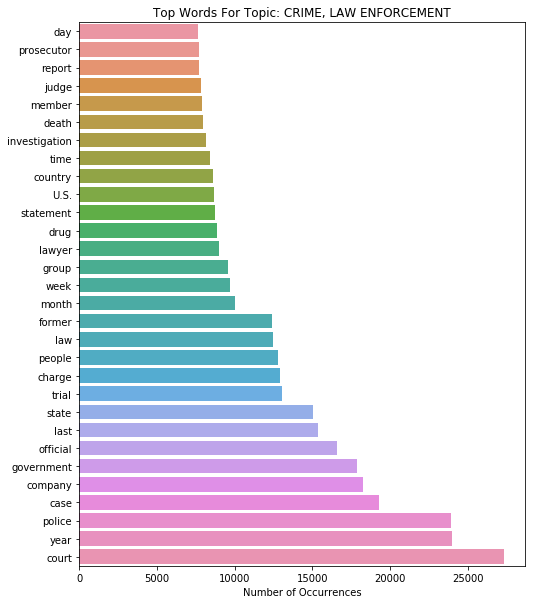

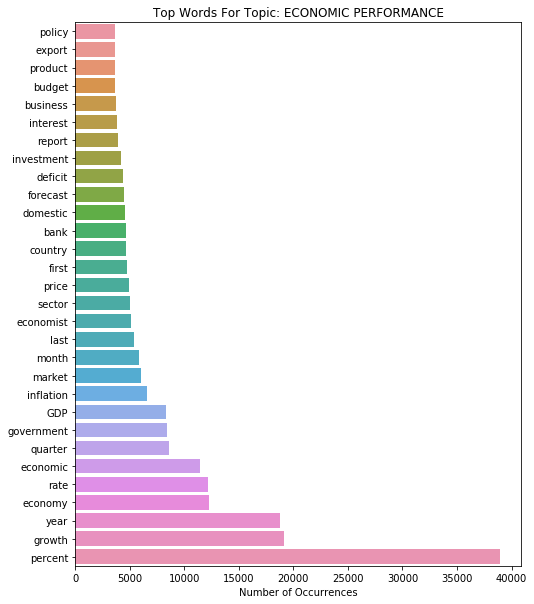

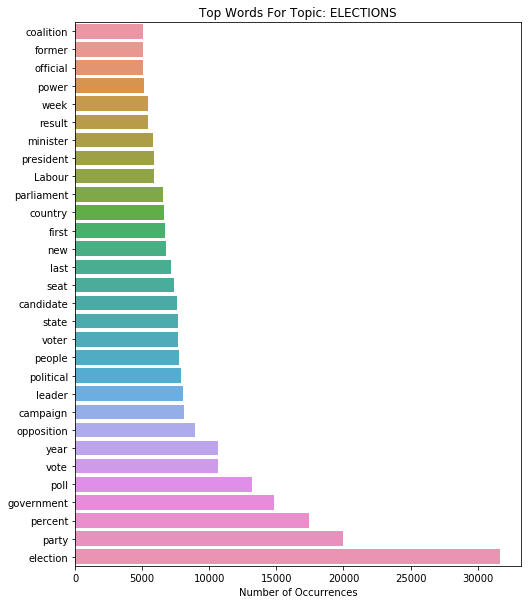

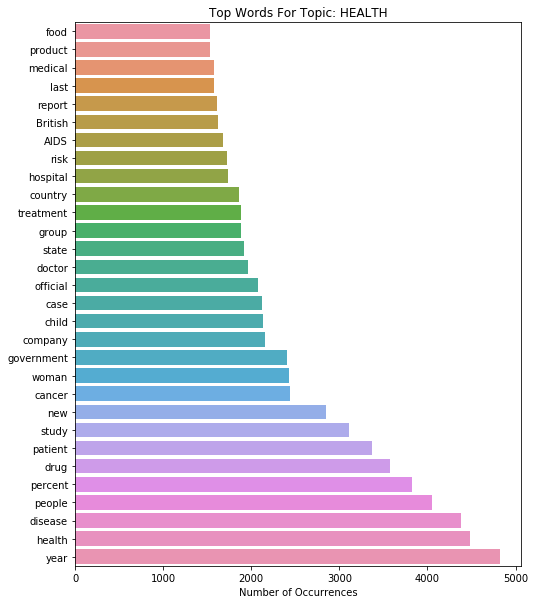

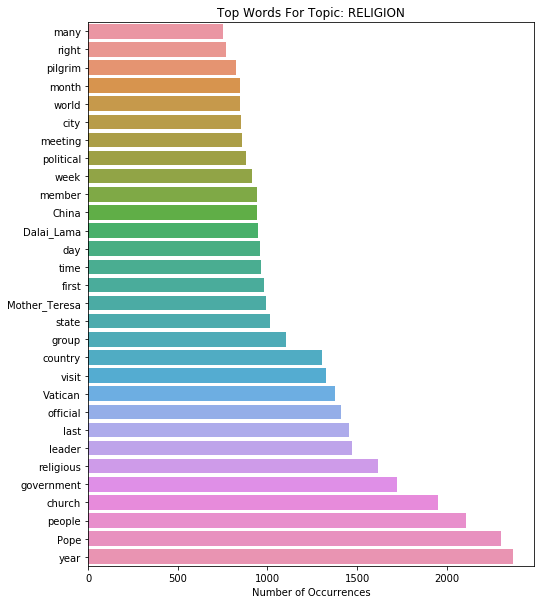

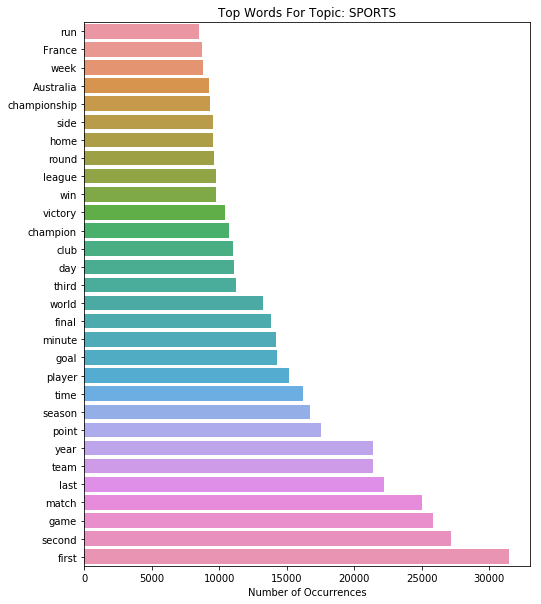

In [59]:
# Plot the top words per topic
for topic, top_words in top_words_per_topic.items():
    x = []
    y = []
    
    readable_topic = topic_code_to_topic_dict[int_to_topic_code[topic]]
    
    for count, word in top_words:
        y.append(word)
        x.append(count)

    plt.figure(figsize=(8, 10))
    plt.title('Top Words For Topic: {}'.format(readable_topic))
    plt.xlabel('Number of Occurrences')
    sns.barplot(x=x, y=y)
    plt.show()

In [83]:
# Try out some symonyms and related terms

# Crime and Law Enforcement
lawyer_embedding = embedding_model.get_vector('lawyer')
attorney_embedding = embedding_model.get_vector('attorney')
print_similarity(lawyer_embedding, attorney_embedding, 'lawyer', 'attorney')

# Economic Performance
deficit_embedding = embedding_model.get_vector('economist')
shortfall_embedding = embedding_model.get_vector('economy')
print_similarity(deficit_embedding, shortfall_embedding, 'economist', 'economy')

# Elections
bill_clinton_embedding = embedding_model.get_vector('Bill Clinton')
george_bush_embedding = embedding_model.get_vector('George Bush')
print_similarity(bill_clinton_embedding, george_bush_embedding, 'Bill Clinton', 'George Bush')

# Health
cancer_embedding = embedding_model.get_vector('cancer')
disease_embedding = embedding_model.get_vector('disease')
print_similarity(cancer_embedding, disease_embedding, 'cancer', 'disease')

# Religion
dalai_lama_embedding = embedding_model.get_vector('Dalai Lama')
mother_teresa_embedding = embedding_model.get_vector('Mother Teresa')
print_similarity(dalai_lama_embedding, mother_teresa_embedding, 'Dalai Lama', 'Mother Teresa')

# Sports
game_embedding = embedding_model.get_vector('game')
match_embedding = embedding_model.get_vector('match')
print_similarity(game_embedding, match_embedding, 'game', 'match')

Cosine similarity between lawyer and attorney is 0.9357
Cosine similarity between economist and economy is 0.4753
Cosine similarity between Bill Clinton and George Bush is 0.4996
Cosine similarity between cancer and disease is 0.8776
Cosine similarity between Dalai Lama and Mother Teresa is 0.6897
Cosine similarity between game and match is 0.8964


In [98]:
# Plot a table representation of the above cosine similarities
phrases = ['lawyer       ',
           'attorney     ',
           'economist    ',
           'economy      ',
           'Bill Clinton ',
           'George Bush  ',
           'cancer       ',
           'disease      ',
           'Dalai Lama   ',
           'Mother Teresa',
           'game         ',
           'match        ']

embeddings = [embedding_model.get_vector(phrase.strip()) for phrase in phrases]

for i in range(len(phrases)):
    
    to_print = phrases[i] + '\t'
    
    for j in range(len(phrases)):
        
        to_print += '{:.4f}\t'.format(cosine_similarity(embeddings[i][np.newaxis, :], 
                                                        embeddings[j][np.newaxis, :])[0,0])
    
    print(to_print)

lawyer       	1.0000	0.9357	0.0453	0.0891	0.2493	0.1428	0.0264	0.0268	0.0815	0.0209	0.0521	0.0247	
attorney     	0.9357	1.0000	0.0346	0.0805	0.2914	0.1185	0.0279	0.0291	0.0799	0.0165	0.0559	0.0323	
economist    	0.0453	0.0346	1.0000	0.4753	0.1098	0.0228	0.0112	0.0197	0.0252	0.0123	0.0846	0.0331	
economy      	0.0891	0.0805	0.4753	1.0000	0.2299	0.1478	0.0263	0.0476	0.0908	0.0436	0.0976	0.0477	
Bill Clinton 	0.2493	0.2914	0.1098	0.2299	1.0000	0.4996	0.0486	0.0294	0.2837	0.0643	0.0643	0.0568	
George Bush  	0.1428	0.1185	0.0228	0.1478	0.4996	1.0000	0.1236	0.1329	0.4480	0.2684	0.1620	0.0888	
cancer       	0.0264	0.0279	0.0112	0.0263	0.0486	0.1236	1.0000	0.8776	0.0133	0.0186	0.0856	0.0334	
disease      	0.0268	0.0291	0.0197	0.0476	0.0294	0.1329	0.8776	1.0000	0.0016	0.0161	0.1001	0.0358	
Dalai Lama   	0.0815	0.0799	0.0252	0.0908	0.2837	0.4480	0.0133	0.0016	1.0000	0.6897	0.0695	0.0221	
Mother Teresa	0.0209	0.0165	0.0123	0.0436	0.0643	0.2684	0.0186	0.0161	0.6897	1.0000	0.0581	0.0075	
game      